## Lab 1: Monte Carlo Markov Chain ##



In [1]:
# Imports
import numpy as np
import scipy.stats as sci
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from collections import defaultdict

In [2]:
phi=0.5
n_disks=1000
l = np.sqrt((np.pi*n_disks)  / (4*phi))
print(l)

39.633272976060105


In [6]:
""" def hexGrid(sigma,n_disks,Lx,Ly):
    d_0 = 2 * sigma
    sqrt3 = np.sqrt(3)
    y_sep = d_0 * sqrt3/2
    err=1e-8
    hexgrid=[]
    lim = np.ceil(np.sqrt(n_disks))
    col = np.arange(sigma,lim*y_sep,y_sep)

    for _,j in enumerate(col):
        x_offset=sigma if _%2==1 else 0
        row = np.arange(sigma+x_offset,(2*lim)+sigma,d_0)
        for __,i in enumerate(row):
            hexgrid.append([i,j])
    hexgrid=np.array(hexgrid,dtype=float)
    #hexgrid[:,0]=hexgrid[:,0]-(lim)
    #hexgrid[:,1]=hexgrid[:,1]-(sqrt3*lim/2)
    #L = np.max([(np.ptp(hexgrid[:,0])+d_0), (np.ptp(hexgrid[:,1])+d_0)])
    hexgrid[:, 0] -= np.mean(hexgrid[:, 0])
    hexgrid[:, 1] -= np.mean(hexgrid[:, 1])

    # total span (for box size reference)
    L = max(np.ptp(hexgrid[:, 0]) + d_0, np.ptp(hexgrid[:, 1]) + d_0)
    return hexgrid, L

def generateGrid(sigma, n_disks, Lx,Ly,factor, random):
    hg,L=hexGrid(sigma,(n_disks*factor),(Lx*factor),(Ly*factor))
    hg=np.array(hg)

    scale_x = (Lx - 2*sigma) / np.ptp(hg[:, 0])
    scale_y = (Ly - 2*sigma) / np.ptp(hg[:, 1])
    hg[:, 0] *= scale_x
    hg[:, 1] *= scale_y

    # center
    hg[:, 0] -= np.mean(hg[:, 0])
    hg[:, 1] -= np.mean(hg[:, 1])

    if random:
        chosen = np.random.choice(len(hg), n_disks, replace=False)
        return hg[chosen], L
    else:
        return hg[:n_disks], L
    if random==True:
        hg[:,0] = Lx*((hg[:,0]-(np.min(hg[:,0])+sigma))/(np.ptp(hg[:,0]))) -((Ly-(2*sigma))/2) #normalize
        hg[:,1] = Ly*((hg[:,1]-(np.min(hg[:,1])+sigma))/(np.ptp(hg[:,1]))) -((Ly-(2*sigma))/2) #normalize
        random_hex = np.random.choice(len(hg), n_disks, replace=False)
        return hg[random_hex], L
    else:
        return hg[:n_disks],L
 """
def graphDisks(hexgrid, graph_lim, sigma=1):
    graph_lim += (sigma*2)
    fig, ax=plt.subplots(figsize=(8,8))
    err=1e-10
    for _,h in enumerate(hexgrid):
        facecolor="red" if _==0 else "lightgray"
        c=plt.Circle((h[0],h[1]),sigma,facecolor=facecolor, edgecolor="black")
        ax.add_patch(c)
        edgecolor="black"
        margin=(2*graph_lim)-sigma+err
        if np.abs(h[0])> margin:
            dir=-1 if h[0]<0 else 1
            _c=plt.Circle((h[0]-(2*graph_lim*dir),h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)

        if np.abs(h[1])>margin:
            dir=-1 if h[1]<0 else 1
            _c=plt.Circle((h[0],h[1]-(2*graph_lim*dir)),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        ax.set_xlim(-graph_lim,graph_lim)
        ax.set_ylim(-graph_lim,graph_lim)
    ax.set_aspect("equal")
    return ax

def sortIntoGrid(hexgrid, sigma, Lx, Ly):
    nx = int(np.ceil(Lx/(2*sigma)))
    ny = int(np.ceil(Ly/(2*sigma)))
    print(nx)
    print(ny)
    boxes = [[[] for _ in range(ny)] for _ in range(nx)]
    disk_loc = hexgrid.copy()
    for d, disk in enumerate(hexgrid):
        x_box = int((disk[0]+Lx/2) / (2*sigma))
        y_box = int((disk[1]+Ly/2) / (2*sigma))
        boxes[x_box][y_box].append(d)
        disk_loc[d] = [x_box, y_box]
    return boxes, disk_loc


# In: disk locations
# Out: list of neighbors indices
def getNeighbors(boxes, disk, d, Lx, Ly, sigma, pbc=True):
    x_box = int((disk[0] + Lx/2) // (2*sigma))
    y_box = int((disk[1] + Ly/2) // (2*sigma))

    nx = len(boxes)
    ny = len(boxes[0])

    # handle PBC for box indices
    if pbc:
        x_box %= nx
        y_box %= ny
    else:
        if x_box < 0 or x_box >= nx or y_box < 0 or y_box >= ny:
            indices_to_check = []  # outside the grid
        else:
            indices_to_check = []

    indices_to_check = boxes[x_box][y_box].copy()
    for dx in [-2,-1, 0, 1,2]:
        for dy in [-2,-1, 0, 1,2]:
            if dx == 0 and dy == 0:
                continue
            ni = (x_box + dx) % nx if pbc else x_box + dx
            nj = (y_box + dy) % ny if pbc else y_box + dy
            if 0 <= ni < nx and 0 <= nj < ny:
                indices_to_check.extend(boxes[ni][nj])
    if d in indices_to_check:
        indices_to_check.remove(d)
    #print(indices_to_check)
    return indices_to_check
   

def checkNeighbors(hexgrid, disk,d, nghbrs, sigma, Lx, Ly, pbc):
    overlap = False
    for j in nghbrs:
        #print(f"{d}[{disk[0]:.2f},{disk[0]:.2f}] -> {j}[{hexgrid[j][0]:.2f},{hexgrid[j][1]:.2f}]")
        dx = disk[0] - hexgrid[j][0]
        dy = disk[1] - hexgrid[j][1]
        if pbc:
            dx -= Lx * round(dx / Lx)
            dy -= Ly * round(dy / Ly)
        if (dx**2 + dy**2) < (2*sigma)**2:
            overlap = True
            return overlap
    return overlap

def updateGrid(d, disk, disk_loc, boxes, sigma, Lx, Ly):
    oldxbox,oldybox=int(disk_loc[d][0]),int(disk_loc[d][1])
    x_box = int((disk[0]+Lx/2) / (2*sigma))
    y_box = int((disk[1]+Ly/2) / (2*sigma))
    if x_box!=disk_loc[d][0] or y_box !=disk_loc[d][1]:
        boxes[oldxbox][oldybox].remove(d)
        boxes[x_box][y_box].append(d)
    disk_loc[d] = [x_box, y_box]

    return disk_loc, boxes

def monteCarlo(hexgrid, disk_loc, boxes, num_steps, sigma, Lx, Ly):
    md = 0.0
    ms=0
    pbc=True
    for n in range(num_steps):
        d = np.random.randint(0,num_steps)
        disk = hexgrid[d]
        old_pos=disk.copy()
        delta=0.1
        dx = np.random.uniform()-0.5
        dy = np.random.uniform()-0.5
        new_disk = [old_pos[0]+(delta*dx), old_pos[1]+(delta*dy)]
        for _,_d in enumerate(hexgrid):
            dx = new_disk[0] - _d[0]
            dy = new_disk[1] - _d[1]
            if pbc:
                dx -= Lx * round(dx / Lx)
                dy -= Ly * round(dy / Ly)
            if (dx**2 + dy**2) < (2*sigma)**2:
                continue
                """ nghbrs=getNeighbors(boxes, new_disk, d, Lx, Ly, sigma, pbc=True)
                _move=checkNeighbors(hexgrid, new_disk,d, nghbrs, sigma, Lx, Ly, pbc=True) 
                if _move==False: """
            else:
                hexgrid[d] = new_disk
                #disk_loc, boxes = updateGrid(d, new_disk, disk_loc, boxes, sigma, Lx, Ly)
                #move_distance = np.sqrt((new_disk[0]-old_pos[0])**2 + (new_disk[1]-old_pos[1])**2)
                #ms += 1
                #md += move_distance
    return hexgrid, boxes, md


In [7]:
def generateGrid(sigma, n_disks, Lx, Ly, factor=1.5, random=True, phi=0.4):
    # box size from area fraction
    L = np.sqrt(n_disks * np.pi * sigma**2 / phi)
    Lx = Ly = L

    # hex lattice spacing
    d0 = 2*sigma
    y_sep = d0 * np.sqrt(3)/2

    # number of points along x/y (oversize slightly for random selection)
    nx = int(np.ceil(L/d0 * factor))
    ny = int(np.ceil(L/y_sep * factor))

    # build lattice
    hg = [[i*d0 + (d0/2 if j%2 else 0), j*y_sep] for j in range(ny) for i in range(nx)]
    hg = np.array(hg)
    hg[:,0] -= np.mean(hg[n_disks:,0])
    hg[:,1] -= np.mean(hg[n_disks:,1])

    # ensure enough points
    if len(hg) < n_disks:
        raise ValueError("Lattice too small for requested n_disks at given phi.")

    # pick n_disks
    if random:
        idx = np.random.choice(len(hg), n_disks, replace=False)
        hg = hg[idx]
    else:
        hg = hg[-n_disks:]

    return hg, Lx, Ly


45
45
0 - 0.0
Number of disks: 1024
Box size: 89.67985946236686 89.67985946236686
Area fraction approx: 0.39999999999999997
0.39999999999999997
Minimum center distance: 1.5459874838311465
Expected 2*sigma = 2


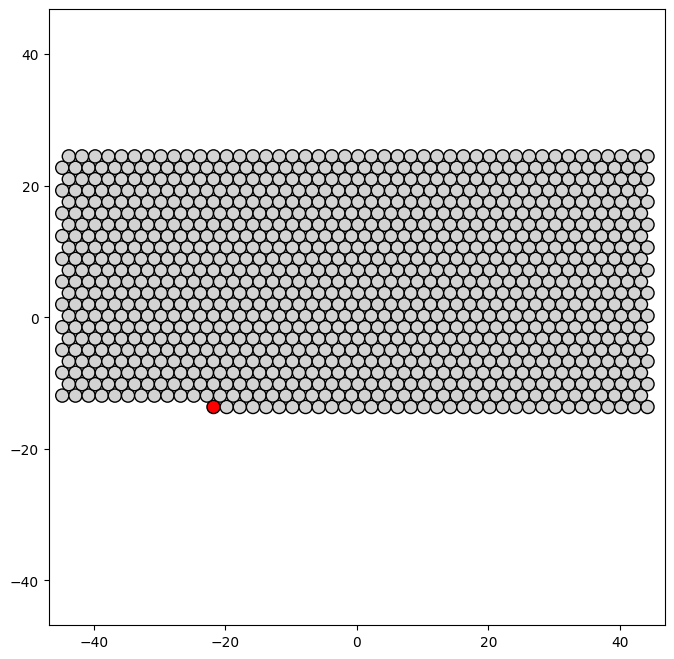

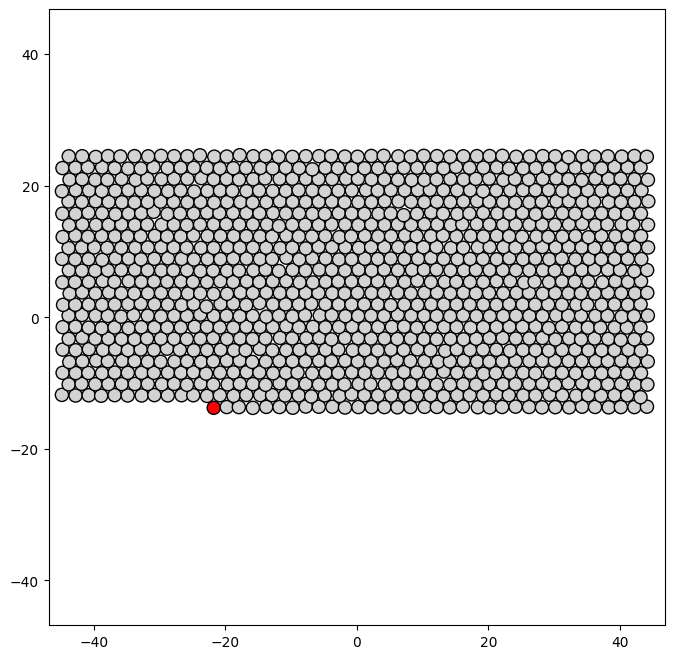

In [9]:
sigma = 1
phi = 0.4
n_disks = 1024
L = np.sqrt((np.pi * sigma**2 * n_disks) / (phi))
Lx=Ly=L
pbc=True
random=False
factor=1 if random==True else 1
#hexgrid, bounding_Lx,bounding_Ly = generateGrid(sigma,n_disks,Lx,Ly,factor,random, phi)

hg, Lx, Ly = generateGrid(sigma, n_disks, 0, 0, factor=factor, random=random, phi=phi)
boxes, disk_loc = sortIntoGrid(hg,sigma,Lx,Ly)

ax = graphDisks(hg, L/2)

m=5
for n in range(m):

    hg, boxes, moves = monteCarlo(hg, disk_loc, boxes, n_disks, sigma, Lx, Ly)
    if n % 10==0:
        print(f"{n} - {moves}")

print("Number of disks:", len(hg))
print("Box size:", Lx, Ly)
print("Area fraction approx:", n_disks * np.pi * sigma**2 / (Lx*Ly))

ax = graphDisks(hg, L/2)
_phi = (np.pi*n_disks) / ((L**2))
print(_phi)
from scipy.spatial.distance import pdist
min_dist = np.min(pdist(hg))
print("Minimum center distance:", min_dist)
print("Expected 2*sigma =", 2*sigma)


In [ ]:
def sort_into_cells(positions, sigma, Lx, Ly):
    w = 2 * sigma
    nx, ny = int(Lx // w), int(Ly // w)
    cells = defaultdict(list)

    for i, (x, y) in enumerate(positions):
        ix = int(np.floor((x + Lx / 2) / w)) % nx
        iy = int(np.floor((y + Ly / 2) / w)) % ny
        cells[(ix, iy)].append(i)
    return cells, (nx, ny)

def neighbor_cells(ix, iy, nx, ny, pbc=True):
    nbrs = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx_ = (ix + dx) % nx if pbc else ix + dx
            ny_ = (iy + dy) % ny if pbc else iy + dy
            if 0 <= nx_ < nx and 0 <= ny_ < ny:
                nbrs.append((nx_, ny_))
    return nbrs

def in_bounds(pos, sigma, Lx, Ly):
    return (-Lx/2+sigma <= pos[0] <= Lx/2-sigma) and (-Ly/2+sigma <= pos[1] <= Ly/2-sigma)

def overlaps(i, pos, positions, sigma, Lx, Ly, cells, nx, ny, pbc=True):
    w = 2 * sigma
    ix = int(np.floor((pos[0] + Lx / 2) / w)) % nx
    iy = int(np.floor((pos[1] + Ly / 2) / w)) % ny
    for (jx, jy) in neighbor_cells(ix, iy, nx, ny, pbc):
        for k in cells[(jx, jy)]:
            if k == i: continue
            dx = pos[0] - positions[k, 0]
            dy = pos[1] - positions[k, 1]
            if pbc:
                dx -= Lx * np.rint(dx / Lx)
                dy -= Ly * np.rint(dy / Ly)
            else:
                if not in_bounds(pos, sigma, Lx, Ly):
                    return True
            if dx*dx + dy*dy < (2*sigma)**2 - 1e-12:
                return True
    return False

def simulate(positions, sigma, Lx, Ly, steps=500, d=0.1, pbc=True):
    positions = np.array(positions)
    cells, (nx, ny) = sort_into_cells(positions, sigma, Lx, Ly)
    n = len(positions)

    for t in range(steps):
        for _ in range(n):
            i = np.random.randint(n)
            old = positions[i].copy()
            new = old + np.random.uniform(-d, d, 2)

            # Apply periodic wrapping only if PBC
            if pbc:
                new[0] = ((new[0] + Lx/2) % Lx) - Lx/2
                new[1] = ((new[1] + Ly/2) % Ly) - Ly/2

            if not overlaps(i, new, positions, sigma, Lx, Ly, cells, nx, ny, pbc):
                positions[i] = new
                # update cell assignment if needed
                w = 2 * sigma
                ix_old = int(np.floor((old[0] + Lx / 2) / w)) % nx
                iy_old = int(np.floor((old[1] + Ly / 2) / w)) % ny
                ix_new = int(np.floor((new[0] + Lx / 2) / w)) % nx
                iy_new = int(np.floor((new[1] + Ly / 2) / w)) % ny
                if (ix_old, iy_old) != (ix_new, iy_new):
                    cells[(ix_old, iy_old)].remove(i)
                    cells[(ix_new, iy_new)].append(i)
    return positions

In [ ]:

ax = graphDisks(hexgrid, (L)/2)
_phi = (np.pi*n_disks) / (4*(L**2))
print(_phi)

In [ ]:
sigma=1
phi=0.1
n_disks=1024
L = (np.sqrt((np.pi*(sigma**2)*n_disks)  / (4*phi)))
Lx,Ly=L,L
random_L = np.ceil(np.sqrt(n_disks*(1/phi)))
random_Lx,random_Ly=random_L,random_L
random=True
graph_lim = np.ceil(random_L/2)+sigma if random==True else np.ceil(L/2)
if random==True:
    hexgrid, bounding_L = randomGrid(sigma,n_disks,L,L, 1)   
    ax = graphDisks(hexgrid, (L)/2)
    _phi = (np.pi*n_disks) / (4*(L**2))
else:
    hexgrid, bounding_L = hexGrid(sigma,n_disks,Lx,Ly)
    
    ## DO A FEW STEPS AT d=0.1 TO GET TO ERGODIC POS

    ax = graphDisks(hexgrid, (L)/2)
    _phi = (np.pi*n_disks) / (4*((L)**2))
    
print(f"n_disks={len(hexgrid)}, L:{L:.2f} calculated phi: {_phi:.3f}")
plt.show()

## Make grid, add members to grid. 
## density calc is necessary too
## 


""" disk_tracking = np.zeros((n_disks,tot_time, 2))
time_lag_msd = np.zeros((n_disks,tot_time))
print(disk_tracking.shape)
print(disks.shape)
disk_tracking[:,0,:]=disks.copy()
graph_positions(disks, L_x,L_y, sigma, phi, coords, 0,4) """



In [ ]:
# Functions

# Generate and Populate Grid
def generate_hex_grid_teller(sigma, L_x, L_y, grid):
    sigma=2*sigma
    sqrt3 = np.sqrt(3)
    dy =sigma * sqrt3/2  # vertical spacing between rows
    err=1e-10
    
    # Ordered Generation
    if grid==True:
        # y positions
        _y_vals = np.arange(-L_y/2, L_y/2 + err, dy)
        y_vals = np.flip(_y_vals)
        positions = []
        for j, y in enumerate(y_vals):
            # shift every other row by (2)sigma/2
            x_offset = 0.5 * sigma if j % 2 else 0.0
            x_vals = np.arange(-L_x/2 + x_offset, L_x/2 + err, sigma)
            for x in x_vals:
                if (np.abs(x) <= L_x/2 - sigma+err) and (np.abs(y) <= L_y/2 - sigma+err):
                    positions.append([x, y])
        print(f"({len(x_vals)} {j})")

    # Random config
    else:
        y_vals = np.arange((-L_y/2)+(sigma)+err, (L_y/2)-(sigma)+err, dy)
        positions = []
        for j, y in enumerate(y_vals):
            x_offset = 0.5 * sigma if j % 2 else 0.0
            x_vals = np.arange((-L_x/2)+(sigma)+err + x_offset, (L_x/2)-(sigma)+err, sigma)
            for x in x_vals:
                if (np.abs(x) < L_x/2 - (sigma+err)) and (np.abs(y) < L_y/2 - (sigma+err)):
                    positions.append([x, y])
        print(f"({len(x_vals)} {len(y_vals)})")
    return np.array(positions)

def generate_initial_positions(sigma, L_x, L_y, phi, n_disks, grid):
   
    # Generate Triangle Lattice and # disks from packing frac
    lattice=generate_hex_grid_teller(sigma,L_x,L_y, grid) 
    print(f"phi:{phi}, n={n_disks}")

    # Distribute circles -> positions
    disks = []
    if grid==False: # random 
        idx = np.random.choice(len(lattice), n_disks, replace=False)
    else: # hex grid
        idx=np.arange(n_disks)
    disks=lattice[np.sort(np.asarray(idx,dtype=int))]
    return disks

def graph_positions(disks, L_x, L_y, sigma, phi, coords, move_idx, size):
    fig,ax=plt.subplots(figsize=(size,size*int(L_y/L_x)))
    edgecolor="None"
    err=1e-9
    for _,i in enumerate(disks):
        c=plt.Circle((i[0],i[1]),sigma,facecolor="gray", edgecolor=edgecolor)
        if i[0] < sigma+err:
            _c=plt.Circle((i[0]+L_x,i[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if i[0]> L_x/2 - sigma + err:
            _c=plt.Circle((i[0]-L_x,i[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if i[1]<sigma + err:
            _c=plt.Circle((i[0],i[1]+L_y),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if i[1]>L_y/2 - sigma + err:
            _c=plt.Circle((i[0],i[1]-L_y),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        ax.add_patch(c)
    ax.set_xlim(-L_x/2,L_x/2)
    ax.set_ylim(-L_y/2,L_y/2)
    plt.show()
    return ax

def mc_step(disks, L_x, L_y, sigma, d, periodic,hardwall, g, m):
    # Select random disk + random jump
    rand_disk = np.random.randint(0,len(disks))
    prev_pos = disks[rand_disk].copy()
    dx = np.random.uniform()-0.5
    dy = np.random.uniform()-0.5

    new_pos=prev_pos+np.array([d*dx, d*dy])
    new_pos=np.asarray(new_pos)
    
    err=1e-11
    msd=((new_pos[0]-prev_pos[0])**2 + (new_pos[0]-prev_pos[0])**2) #pre boundary wrap
    if periodic==True:
        _new_pos=new_pos
        new_pos[0] = ((new_pos[0] + L_x/2) % L_x) - L_x/2
        new_pos[1] = ((new_pos[1] + L_y/2) % L_y) - L_y/2
        diff = disks - new_pos
        diff -= L_x * np.round(diff / L_x)
        diff -= L_y * np.round(diff / L_y) 
    else:
        if hardwall==True:
            if (abs(new_pos[0]) > (L_x/2 - sigma+err)) or (abs(new_pos[1]) > (L_y/2 - sigma+err)):
                return prev_pos, rand_disk, 0.0
        
        diff = disks - new_pos

    diff_sq = np.sum(diff**2, axis=1)
    diff_sq[rand_disk] = np.inf  # ignore self 

    # check for overlaps
    if np.any(diff_sq < (2 * sigma)**2):
        return prev_pos, rand_disk,0.0
    
    if g!=0.0 and periodic==False:
        # if force acting, calculate prob
        T=1.0
        beta=1.0/T
        dE = m*g*(new_pos[1]-prev_pos[1])
        a=min([1.0, np.exp(-beta*dE)])
        if np.random.rand() < a:
            return new_pos, rand_disk, msd
    else:
        # no collisions = accept move
        dE = 0
        #msd=(new_pos[1] - prev_pos[1])**2 + (new_pos[0] - prev_pos[0])**2
        return _new_pos, rand_disk, msd
    return prev_pos, rand_disk, 0.0

In [ ]:
# run details
deltas=np.array([0.001,0.005,0.01,0.0], dtype=float)

In [ ]:
# Define Variables
phi=0.7 # area fraction
mass=1.0
g=100.0
grid = True # hex grid Y/N

tot_time = 10000
n_disks = num_MC = 100
sigma=1
L=np.sqrt((np.pi*num_MC)/(phi))
print(L)
d=0.1
delta=d*sigma
Lx=L
L_y=L
coords=[0,0]
disks=[]
disks=generate_initial_positions(sigma, Lx, L_y, phi, n_disks, grid)
disk_tracking = np.zeros((n_disks,tot_time, 2))
time_lag_msd = np.zeros((n_disks,tot_time))
print(disk_tracking.shape)
print(disks.shape)
disk_tracking[:,0,:]=disks.copy()
graph_positions(disks, Lx,L_y, sigma, phi, coords, 0,4)

pbc=False
hardwall=not(pbc)
msd_all=np.array([],dtype=float)
mc_choice=[]
_mc_choice=[]
print(f"L=({Lx:.3f},{L_y:.3f})  t={tot_time} g={g} delta={d/sigma:.3f} sigma={sigma}")
for t in range(1,tot_time):
    _msd=0
    for n in range(num_MC):
        new_pos, idx, msd = mc_step(disks, Lx, L_y, sigma, delta, pbc, hardwall, g, mass)
        if msd!=0:
            mc_choice.append(idx)
            disks[idx]=new_pos
            _msd += msd
        else:
            _mc_choice.append(idx)

    msd_all = np.append(msd_all, _msd)
    disk_tracking[:,t,:]=disks
    if t+1 in [1000*k for k in range(10)]:
        graph_positions(disks, Lx, L_y, sigma, phi, new_pos, idx,2)
        print(f"snapshot at time {t}")
        acc = len(mc_choice)/(len(mc_choice)+len(_mc_choice))
        rej = len(_mc_choice)/(len(mc_choice)+len(_mc_choice))
        print(f"accept/reject {acc*100:.3f}%/{rej*100:.3f}%")
graph_positions(disks, Lx, L_y, sigma, phi, new_pos, idx, 2)

## Save Disk Trajectories + Parameters(in file name)


21.184875513271905
(11 12)
phi:0.7, n=100


IndexError: index 90 is out of bounds for axis 0 with size 90

In [ ]:
def run_mc_disk_simulation(tot_time, n_disks, phi, sigma, d, g=0.0, grid=False, pbc=True, snapshot_file="disk_snapshots_3x3.png"):

    mass = 1.0
    hardwall = not pbc
    delta = d * sigma
    L = np.sqrt((np.pi * n_disks) / phi)
    L_x = L
    L_y = L
    coords = [0,0]

    # Initialize positions
    disks = generate_initial_positions(sigma, L_x, L_y, phi, n_disks, grid)
    disk_tracking = np.zeros((n_disks, tot_time, 2))
    disk_tracking[:,0,:] = disks.copy()
    time_lag_msd = np.zeros((n_disks, tot_time))

    # Initial plot (optional, can keep for debug)
    graph_positions(disks, L_x,L_y, sigma, phi, coords, 0,4)

    # Monte Carlo loop
    msd_all = np.array([], dtype=float)
    mc_choice = []
    _mc_choice = []

    print(f"L=({L_x:.3f},{L_y:.3f})  t={tot_time} g={g} delta={d/sigma:.3f} sigma={sigma}")

    for t in range(1, tot_time):
        _msd = 0
        for n in range(n_disks):
            new_pos, idx, msd = mc_step(disks, L_x, L_y, sigma, delta, pbc, hardwall, g, mass)
            if msd != 0:
                mc_choice.append(idx)
                disks[idx] = new_pos
                _msd += msd
            else:
                _mc_choice.append(idx)

        msd_all = np.append(msd_all, _msd)
        disk_tracking[:, t, :] = disks

        # Keep original plotting during the run
        if t+1 in [1000*k for k in range(10)]:
            graph_positions(disks, L_x, L_y, sigma, phi, new_pos, idx,2)
            print(f"snapshot at time {t}")
            acc = len(mc_choice)/(len(mc_choice)+len(_mc_choice))
            rej = len(_mc_choice)/(len(mc_choice)+len(_mc_choice))
            print(f"accept/reject {acc*100:.3f}%/{rej*100:.3f}%")

    # Final plot after MC run
    graph_positions(disks, L_x, L_y, sigma, phi, new_pos, idx, 2)

    disp = disk_tracking - disk_tracking[:, 0, :][:, np.newaxis, :]
    sq_disp = np.sum(disp**2, axis=2)
    mean_sq_disp = np.mean(sq_disp, axis=0)
    total_sq_disp = np.sum(sq_disp, axis=0)

    # Return arrays for further analysis
    return disk_tracking, disp, sq_disp, mean_sq_disp, total_sq_disp

In [ ]:
def graph_positions_on_ax(disks, L_x, L_y, sigma, phi, ax):
    edgecolor="None"
    err=1e-9
    for _,i in enumerate(disks):
        c=plt.Circle((i[0],i[1]),sigma,facecolor="gray", edgecolor=edgecolor)
        if i[0] < sigma+err:
            _c=plt.Circle((i[0]+L_x,i[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if i[0]> L_x/2 - sigma + err:
            _c=plt.Circle((i[0]-L_x,i[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if i[1]<sigma + err:
            _c=plt.Circle((i[0],i[1]+L_y),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if i[1]>L_y/2 - sigma + err:
            _c=plt.Circle((i[0],i[1]-L_y),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        ax.add_patch(c)
    ax.set_xlim(-L_x/4,L_x/4)
    ax.set_ylim(-L_y/4,L_y/4)
    ax.set_aspect('equal')

(124 143)
phi:0.05, n=1000


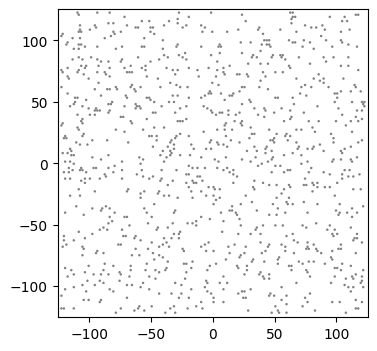

L=(250.663,250.663)  t=1000 g=0.0 delta=0.100 sigma=1


KeyboardInterrupt: 

In [ ]:
n_MC_runs=1000
n_disks=1000
phi=0.05
d=0.1
g=100.0
grid=True
pbc=False
filename=f"phi{phi}-d{d}-t{n_MC_runs}-n{n_disks}.png"
disk_tracking, disp, sq_disp, mean_sq_disp, total_sq_disp = run_mc_disk_simulation(n_MC_runs, n_disks, phi, sigma, d, g=0.0, grid=False, pbc=True, snapshot_file=filename)

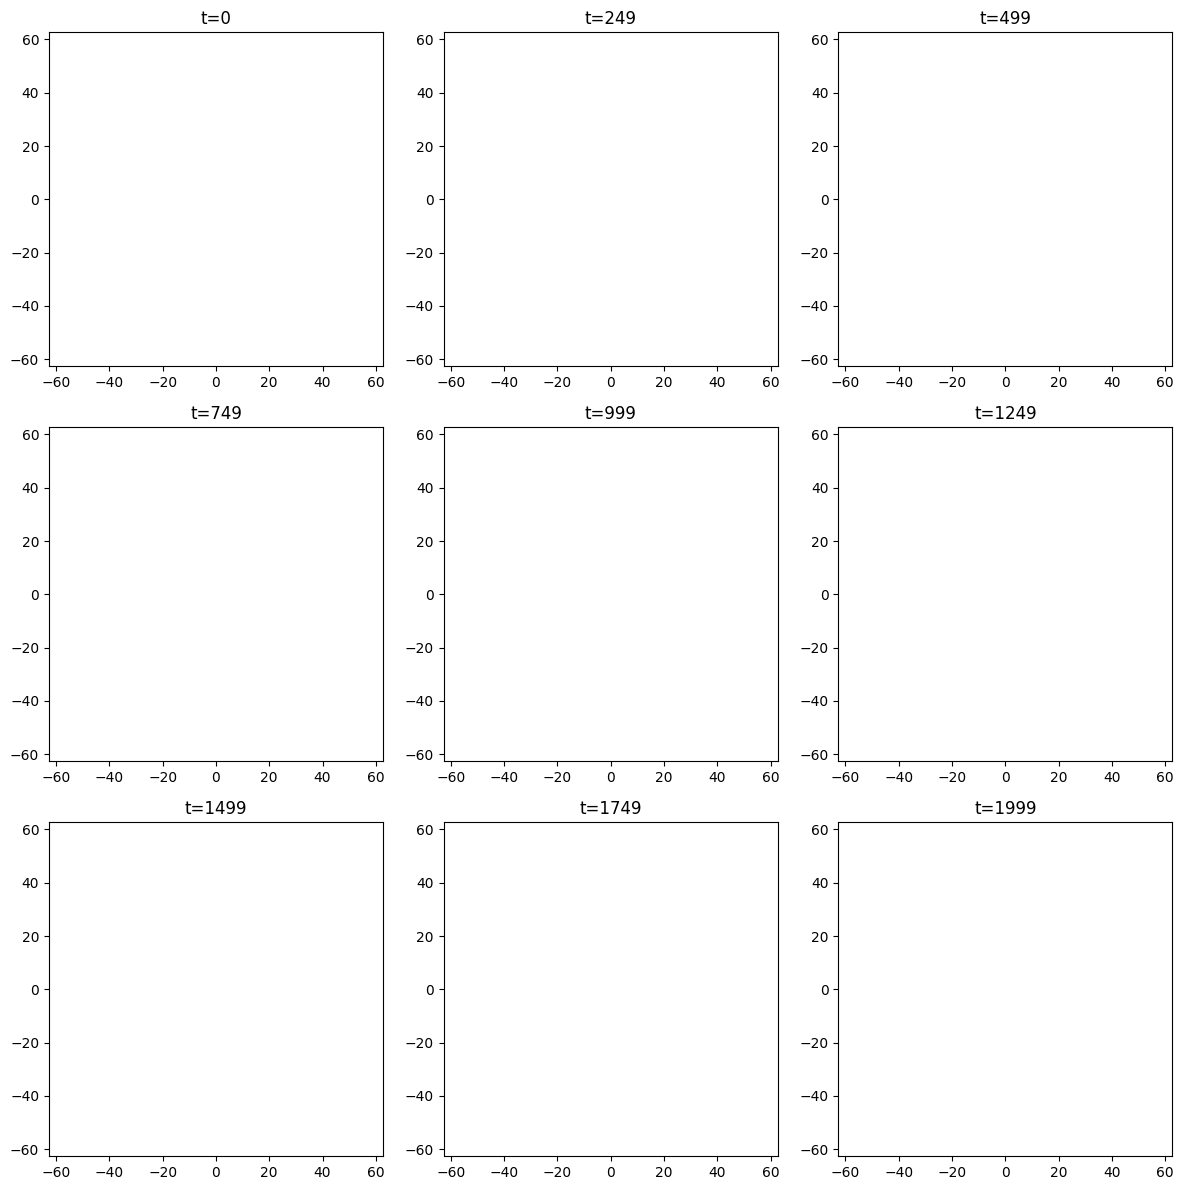

In [ ]:
n_snapshots = 9
tot_time = disk_tracking.shape[1]  # total timesteps
snapshot_times = np.linspace(0, tot_time-1, n_snapshots, dtype=int)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
for h, t_snap in enumerate(snapshot_times):
    ax = axes[h]
    ax.set_title(f"t={t_snap}")
    graph_positions_on_ax(disk_tracking[:, t_snap, :], Lx, L_y, sigma, phi, ax)

plt.tight_layout()
plt.show()

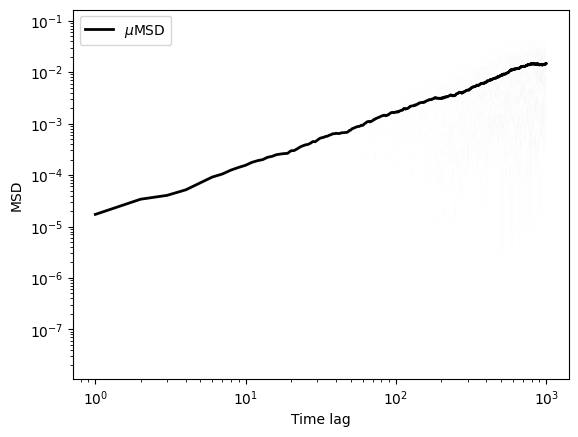

In [ ]:
fig, ax = plt.subplots()
_t = np.arange(tot_time)
disp = disk_tracking - disk_tracking[:, 0, :][:, np.newaxis, :]  
sq_disp = np.sum(disp**2, axis=2)
mean_sq_disp = np.mean(sq_disp,axis=0)
total_sq_disp = np.sum(sq_disp,axis=0)

for n in range(n_disks):
    ax.loglog(_t[1:], sq_disp[n][1:], linewidth=0.05, alpha=0.02, color='black')

ax.loglog(_t[1:],mean_sq_disp[1:], color='k', linewidth=2, label=r'$\mu$MSD')

ax.set_xlabel('Time lag')
ax.set_ylabel('MSD')
ax.legend()

plt.show()

In [ ]:
from scipy.stats import linregress
lag_min, lag_max = 1, min(100, tot_time)  # you can tune this window
lags = _t[lag_min:lag_max]
msd_segment = mean_sq_disp[lag_min:lag_max]

# --- Clean data: remove zeros/nans (important before log) ---
mask = np.isfinite(msd_segment) & (msd_segment > 0)
lags = lags[mask]
msd_segment = msd_segment[mask]

# --- Linear fit for D (normal scale) ---
# MSD(t) ≈ 4 D t  → slope = 4D for 2D Brownian motion
slope, intercept, r_value, p_value, stderr = linregress(lags, msd_segment)
D_est = slope / 4
print(f"Estimated diffusion coefficient D = {D_est:.4g}")

# --- Power-law fit for α (log–log scale) ---
# MSD(t) ≈ A * t^α  → log(MSD) = α log(t) + log(A)
log_lags = np.log(lags)
log_msd = np.log(msd_segment)
alpha, logA, r_value, p_value, stderr = linregress(log_lags, log_msd)
A = np.exp(logA)
print(f"Power-law exponent α = {alpha:.4f}")
print(f"Prefactor A = {A:.4g}")


Estimated diffusion coefficient D = 4.333e-06
Power-law exponent α = 1.0361
Prefactor A = 1.401e-05


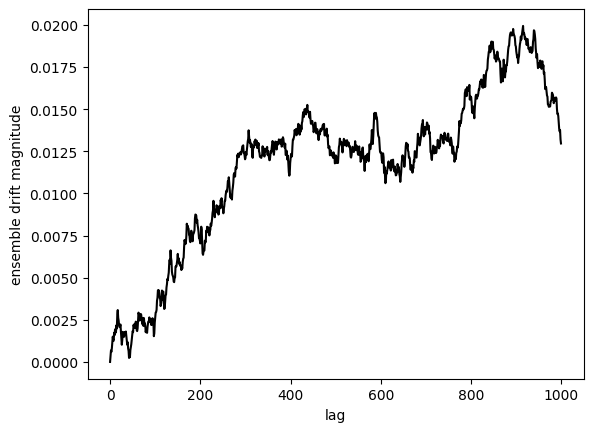

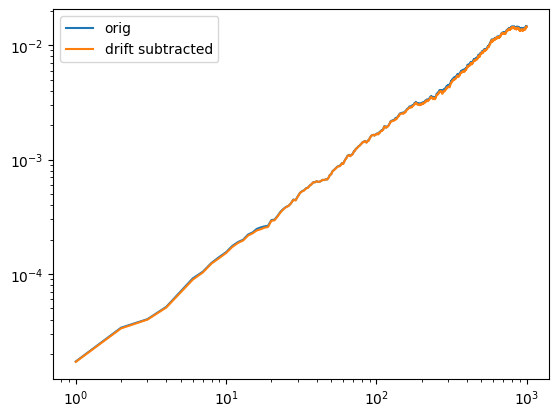

In [ ]:
mean_disp = np.mean(disp, axis=0)   # shape (T, 2)
drift_mag = np.sqrt(np.sum(mean_disp**2, axis=1))

# plot drift magnitude
plt.figure()
plt.plot(_t, drift_mag, '-k')
plt.xlabel('lag'); plt.ylabel('ensemble drift magnitude')
plt.show()

# subtract drift from each particle path and recompute mean MSD
disk_unbiased = disk_tracking - mean_disp[np.newaxis, :, :]   # broadcast remove drift
disp_unbiased = disk_unbiased - disk_unbiased[:, 0, :][:, np.newaxis, :]
msd_unbiased = np.mean(np.sum(disp_unbiased**2, axis=2), axis=0)

# compare original vs drift-subtracted
plt.loglog(_t[1:], mean_sq_disp[1:], label='orig')
plt.loglog(_t[1:], msd_unbiased[1:], label='drift subtracted')
plt.legend(); plt.show()

In [ ]:


def bootstrap_alpha(msd_particles, lags, lag_min, lag_max, nboot=200):
    # msd_particles: shape (N_particles, T)
    idx = np.arange(msd_particles.shape[0])
    alphas = []
    for _ in range(nboot):
        sel = np.random.choice(idx, size=len(idx), replace=True)
        mean_msd_bs = np.mean(msd_particles[sel], axis=0)
        seg = mean_msd_bs[lag_min:lag_max]
        lags_seg = lags[lag_min:lag_max]
        mask = np.isfinite(seg) & (seg>0)
        if mask.sum() < 3:
            continue
        slope, intercept, *_ = linregress(np.log(lags_seg[mask]), np.log(seg[mask]))
        alphas.append(slope)
    return np.array(alphas)

# run bootstrap on per-particle sq_disp (N, T)
alphas_bs = bootstrap_alpha(sq_disp, _t, lag_min=10, lag_max=1000, nboot=400)
print("alpha_bootstrap median, 2.5%, 97.5%:", np.median(alphas_bs), np.percentile(alphas_bs, [2.5,97.5]))
lags_lin = _t[lag_min:lag_max]
msd_lin = mean_sq_disp[lag_min:lag_max]
mask = (msd_lin>0) & np.isfinite(msd_lin)
slope, intercept, *_ = linregress(lags_lin[mask], msd_lin[mask])
D_eff =  slope / 4.0*num_MC  # 2D
print("D_eff (from slope) =", D_eff)


alpha_bootstrap median, 2.5%, 97.5%: 1.0225960559216714 [0.95196136 1.08653825]
D_eff (from slope) = 0.004333351933862806


In [ ]:
time_lag_msd =  np.zeros((n_disks,tot_time))
for t in range(1,tot_time): 
        delt = (disk_tracking[:,t:,0] - disk_tracking[:,:-t,0])**2 + (disk_tracking[:,t:,1] - disk_tracking[:,:-t,1])**2
        time_lag_msd[:,t] = np.mean(delt, axis=1)
        if t%1000==0:
                print(t)

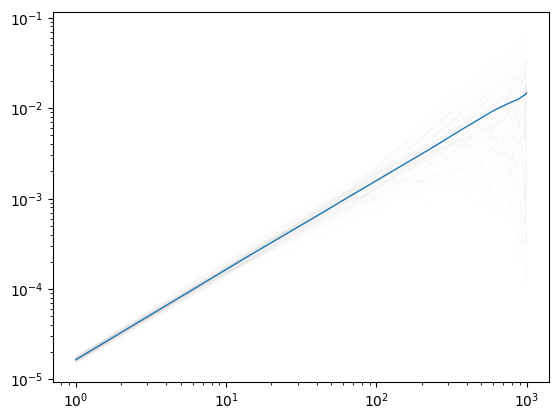

In [ ]:
_t = np.arange(tot_time)
fig,ax=plt.subplots()
for n in range(n_disks):
        ax.loglog((_t[1:]), time_lag_msd[n,1:], linewidth=0.1, alpha=0.1)
ax.loglog((_t[1:]), np.mean(time_lag_msd[:,1:], axis=0), linewidth=1, alpha=1)
plt.show()

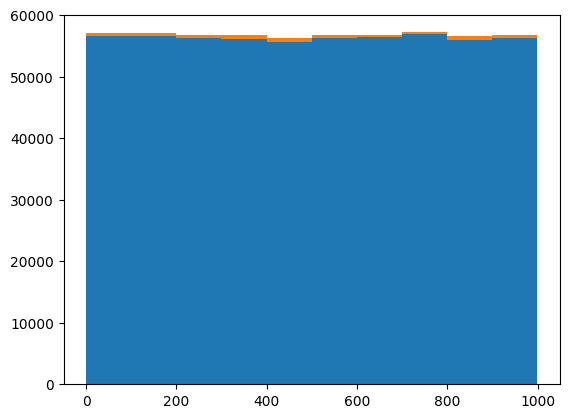

In [ ]:
fig,ax=plt.subplots()
_t = np.arange(tot_time)
#ax.plot(_t, np.cumsum(msd_all))
ax.hist((mc_choice,_mc_choice),histtype="barstacked")
plt.show()